In [1]:
# import the necessary libraries
import numpy as np
import scipy as sp
from scipy.io import loadmat
import h5py
import os
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

os.getcwd()
os.chdir('..')
os.chdir('data')
file_path = os.getcwd() + '/'
os.chdir('..')
os.chdir('figures')
figure_path = os.getcwd() + '/'

### data upload

In [2]:
# uncomment this code if you are uploading the data from your local machine
peak_lat_disp = loadmat(file_path + 'peak_disp_x.mat')
peak_ax_disp = loadmat(file_path + 'peak_disp_y.mat')

# get the lateral particle displacement
lat_part_disp = h5py.File(file_path + 'Xp.mat', 'r')

# get the axial particle displacement
ax_part_disp = h5py.File(file_path + 'Yp.mat', 'r')

In [3]:
# define the data class for easier parsing
class SimSetup:
    def __init__(self, ax_part_disp, lat_part_disp, peak_ax_disp, peak_lat_disp):
        self.ax_part_disp = np.transpose(ax_part_disp['Yp'][()], (2, 1, 0))
        self.lat_part_disp = np.transpose(lat_part_disp['Xp'][()], (2, 1, 0))
        self.peak_ax_disp = peak_ax_disp['peak_disp_yt']
        self.peak_lat_disp = peak_lat_disp['peak_disp_xt']

In [4]:
trxd = SimSetup(ax_part_disp=ax_part_disp,
                lat_part_disp=lat_part_disp,
                peak_ax_disp=peak_ax_disp,
                peak_lat_disp=peak_lat_disp)

In [5]:
# simulation parameters
Nx = 300    # grid points
Ny = 300    # grid points
dx = 0.2e-3 # resolution in x [m]
dy = 0.2e-3 # resolution in y [m]

# Define a dynamic extent for setting the "extent" parameter in matplotlib
def dynamic_extent(x, y):
    return (x * dx * 1e3, (Nx-x) * dx * 1e3,
            (-Ny + 2 * y) * dy * 1e3 / 2, (Ny - 2 * y) * dy * 1e3 / 2)

### Tissue Displacement due to Acoustic Radiation Force

In [6]:
tissue_disp_max = max(np.max(trxd.peak_ax_disp), np.max(trxd.peak_lat_disp))
tissue_disp_min = min(np.min(trxd.peak_ax_disp), np.min(trxd.peak_lat_disp))

# Extract the absolute maximum and absolute minimum values for standardization
absolute_max = max(tissue_disp_max, abs(tissue_disp_min))
absolute_min = min(-tissue_disp_max, tissue_disp_min)

# Normalize to -1 and 1
peak_ax_disp_norm = 2 * (trxd.peak_ax_disp - absolute_min) / (absolute_max -  absolute_min) - 1
peak_lat_disp_norm = 2 * (trxd.peak_lat_disp - absolute_min) / (absolute_max -  absolute_min) - 1

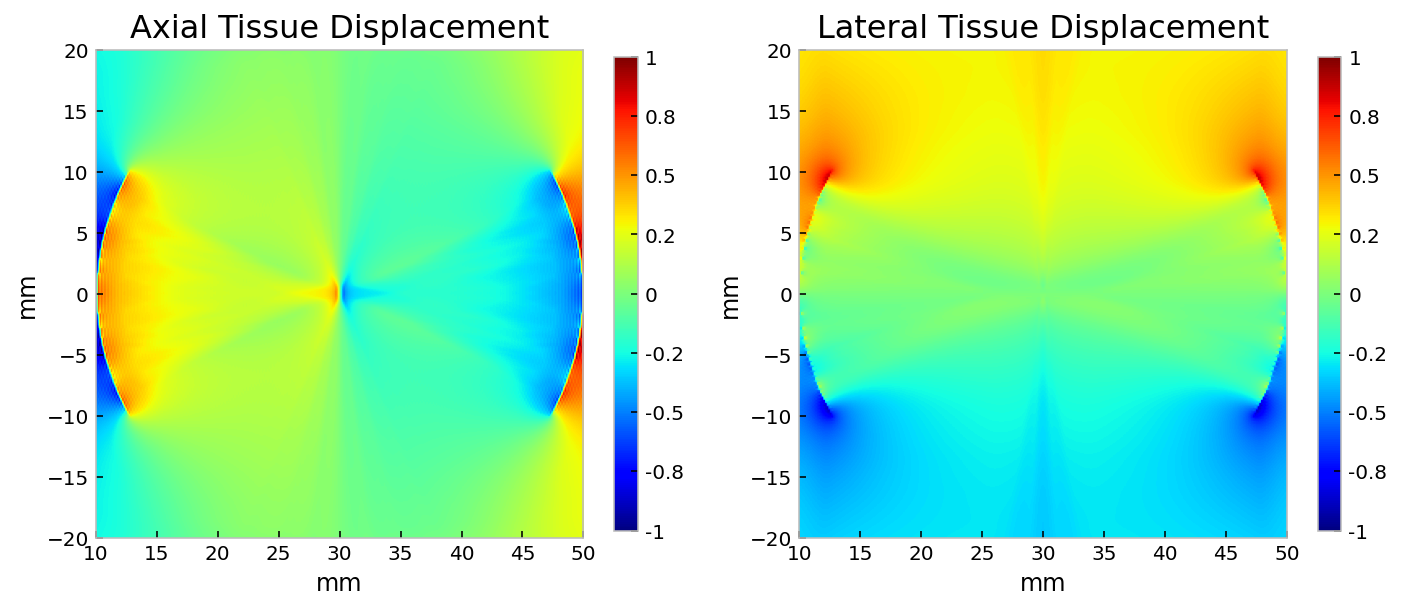

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Axial Tissue Displacement', fontsize=16)
plt.imshow(peak_ax_disp_norm,
           extent=dynamic_extent(50, 50), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('Lateral Tissue Displacement', fontsize=16)
plt.imshow(-peak_lat_disp_norm,
           extent=dynamic_extent(50, 50), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'tissue_displacement.png', dpi=600)
plt.show()

### Particle Displacement due to Pressure

In [8]:
part_disp_max = max(np.max(trxd.ax_part_disp[50:-50, 50:-50, :]), 
                    np.max(trxd.lat_part_disp[50:-50, 50:-50, :]))
part_disp_min = min(np.min(trxd.ax_part_disp[50:-50, 50:-50, :]), 
                    np.min(trxd.lat_part_disp[50:-50, 50:-50, :]))

absolute_max = max(part_disp_max, abs(part_disp_min))
absolute_min = min(-part_disp_max, part_disp_min)

ax_part_disp_norm = 2 * (trxd.ax_part_disp - absolute_min) / (absolute_max -  absolute_min) - 1
lat_part_disp_norm = 2 * (trxd.lat_part_disp - absolute_min) / (absolute_max -  absolute_min) - 1

In [9]:
_, _, t_ax = ind = np.unravel_index(np.argmax(trxd.ax_part_disp[50:-50, 50:-50, :], axis=None), 
                                    trxd.ax_part_disp[50:-50, 50:-50, :].shape)
_, _, t_lat = ind = np.unravel_index(np.argmax(trxd.lat_part_disp[50:-50, 50:-50, :], axis=None), 
                                     trxd.lat_part_disp[50:-50, 50:-50, :].shape)

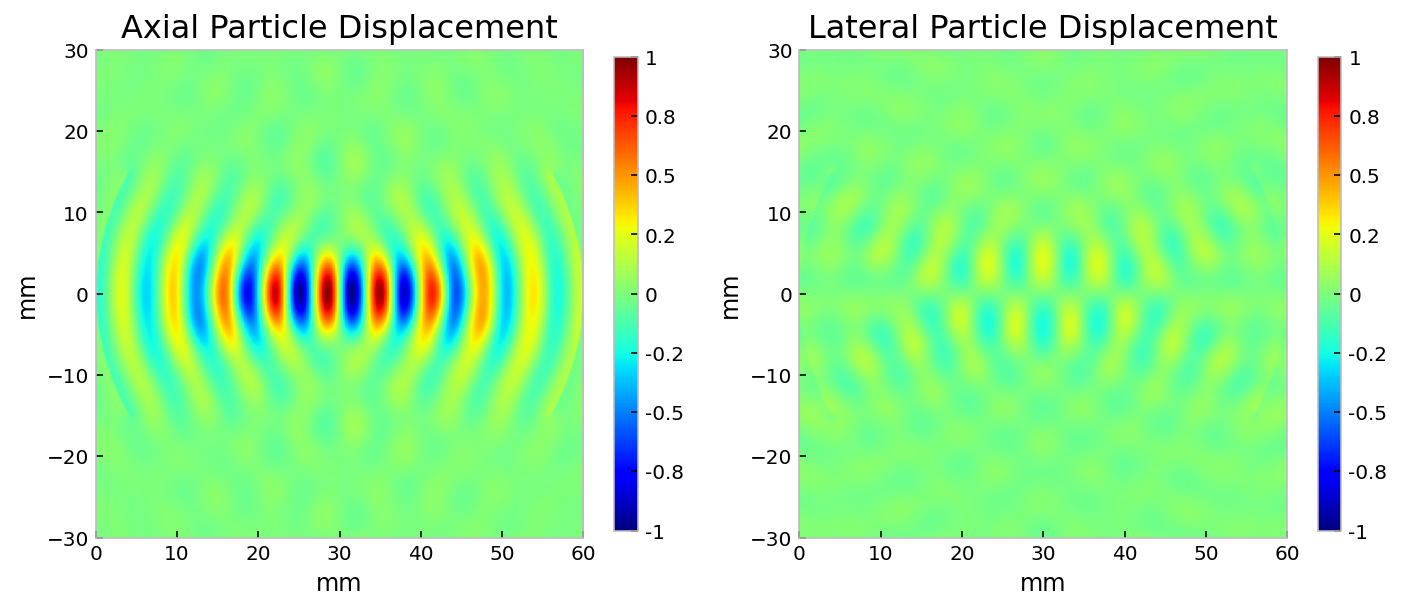

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Axial Particle Displacement', fontsize=16)
plt.imshow(ax_part_disp_norm[:, :, t_ax],
           extent=dynamic_extent(0, 0), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('Lateral Particle Displacement', fontsize=16)
plt.imshow(-lat_part_disp_norm[:, :, t_lat],
           extent=dynamic_extent(0, 0), cmap='jet')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('mm')
plt.ylabel('mm')
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'particle_displacement.png', dpi=600)
plt.show()

### Strain due to Tissue Displacement ($\mathcal{E}^{ARF}$)
Since tissue displacement is caused by acoustic radiation force, we will denote this strain by $\mathcal{E}^{ARF}$.

In [11]:
def compute_strain(ax_disp, lat_disp, res, order=None):
    duxdx = np.gradient(ax_disp, res, axis=1)
    duydy = np.gradient(lat_disp, res, axis=0)
    duxdy = np.gradient(ax_disp, res, axis=0)
    duydx = np.gradient(lat_disp, res, axis=1)

    if order == None or order == "linear":
        e_xx = duxdx
        e_yy = duydy
        e_xy = 0.5 * (duxdy + duydx)
    
    elif order == "nonlinear":
        e_xx = duxdx + duxdx ** 2
        e_yy = duydy + duydy ** 2
        e_xy = 0.5 * (duxdy + duydx + duxdx * duxdy + duydx * duydy)
    
    return e_xx, e_yy, e_xy

In [15]:
ARF_exx, ARF_eyy, ARF_exy = compute_strain(
    trxd.peak_ax_disp, 
    trxd.peak_lat_disp, dx, order='nonlinear')

In [16]:
ARF_strain_max = max(np.max(ARF_exx[50:-50, 50:-50]),
                     np.max(ARF_eyy[50:-50, 50:-50]),
                     np.max(ARF_exy[50:-50, 50:-50]))
ARF_strain_min = min(np.min(ARF_exx[50:-50, 50:-50]),
                     np.min(ARF_eyy[50:-50, 50:-50]),
                     np.min(ARF_exy[50:-50, 50:-50]))

ARF_strain_max = max(ARF_strain_max, abs(ARF_strain_min))
ARF_strain_min = min(-ARF_strain_max, ARF_strain_min)

ARF_exx_norm = 2 * (ARF_exx - ARF_strain_min) / (ARF_strain_max-  ARF_strain_min) - 1
ARF_eyy_norm = 2 * (ARF_eyy - ARF_strain_min) / (ARF_strain_max -  ARF_strain_min) - 1
ARF_exy_norm = 2 * (ARF_exy - ARF_strain_min) / (ARF_strain_max -  ARF_strain_min) - 1

In [17]:
print(f'ARF max normal axial strain: {np.max(abs(ARF_exx_norm[50:-50, 50:-50]))}')
print(f'ARF max normal lateral strain: {np.max(abs(ARF_eyy_norm[50:-50, 50:-50]))}')
print(f'ARF max shear strain: {np.max(abs(ARF_exy_norm[50:-50, 50:-50]))}')

ARF max normal axial strain: 1.0
ARF max normal lateral strain: 0.04372348012358307
ARF max shear strain: 0.12897979133428572


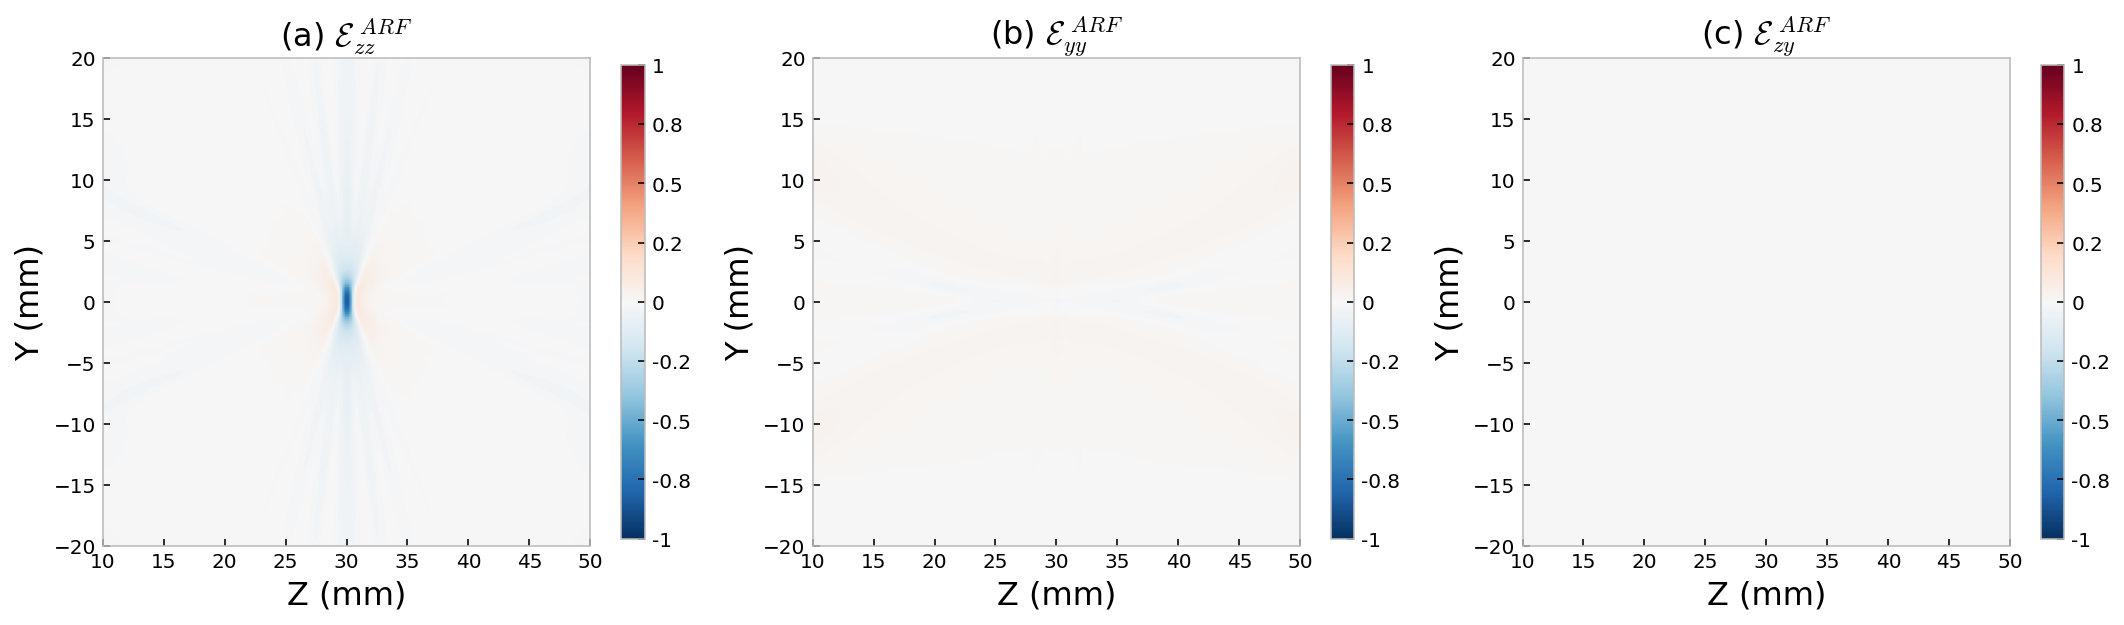

In [18]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('(a) $\mathcal{E}^{\ ARF}_{zz}$', fontsize=16)
plt.imshow(gaussian_filter(ARF_exx_norm[50:-50, 50:-50], 1),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title('(b) $\mathcal{E}^{\ ARF}_{yy}$', fontsize=16)
plt.imshow(gaussian_filter(ARF_eyy_norm[50:-50, 50:-50], 1),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title('(c) $\mathcal{E}^{\ ARF}_{zy}$', fontsize=16)
plt.imshow(gaussian_filter(ARF_exy[50:-50, 50:-50], 1),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'ARF_strain.png', dpi=600)
plt.show()

### Strain due to Particle Displacement ($\mathcal{E}^{PM}$)
Since particle displacement is caused by instantaneous, periodic particle motion under acoustic pressure, we will denote this strain by $\mathcal{E}^{PM}$.

In [19]:
PM_exx, PM_eyy, PM_exy = compute_strain(trxd.ax_part_disp[:, :, t_ax], 
                                        - trxd.lat_part_disp[:, :, -1], dx, order='nonlinear')

In [20]:
PM_strain_max = max(np.max(PM_exx[50:-50, 50:-50]),
                     np.max(PM_eyy[50:-50, 50:-50]),
                     np.max(PM_exy[50:-50, 50:-50]))
PM_strain_min = min(np.min(PM_exx[50:-50, 50:-50]),
                     np.min(PM_eyy[50:-50, 50:-50]),
                     np.min(PM_exy[50:-50, 50:-50]))

PM_strain_max = max(PM_strain_max, abs(PM_strain_min))
PM_strain_min = min(-PM_strain_max, PM_strain_min)

PM_exx_norm = 2 * (PM_exx - PM_strain_min) / (PM_strain_max -  PM_strain_min) - 1
PM_eyy_norm = 2 * (PM_eyy - PM_strain_min) / (PM_strain_max -  PM_strain_min) - 1
PM_exy_norm = 2 * (PM_exy - PM_strain_min) / (PM_strain_max -  PM_strain_min) - 1

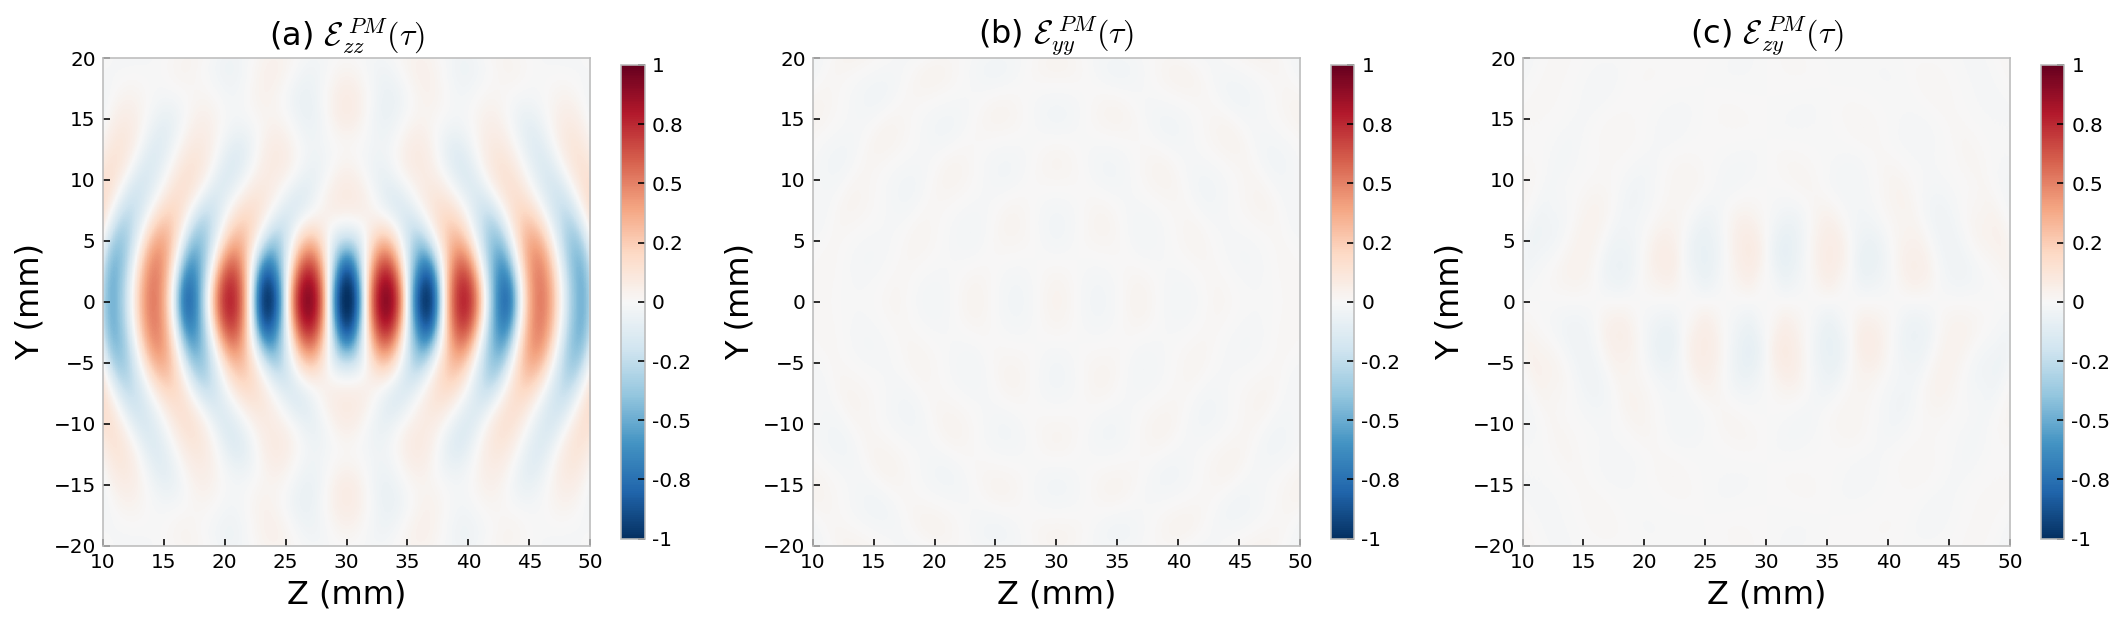

In [21]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title(r'(a) $\mathcal{E}^{\ PM}_{zz} (\tau)$', fontsize=16)
plt.imshow(PM_exx_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title(r'(b) $\mathcal{E}^{\ PM}_{yy} (\tau)$', fontsize=16)
plt.imshow(PM_eyy_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title(r'(c) $\mathcal{E}^{\ PM}_{zy} (\tau)$', fontsize=16)
plt.imshow(PM_exy_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'PM_strain.png', dpi=600)
plt.show()

In [22]:
PM_exx_envelope = np.max(np.gradient(trxd.ax_part_disp[:, :, :], dx, axis=1) , axis=2)

In [23]:
PM_exx_envelope_norm = PM_exx_envelope / np.max(PM_exx_envelope[50:-50, 50:-50])

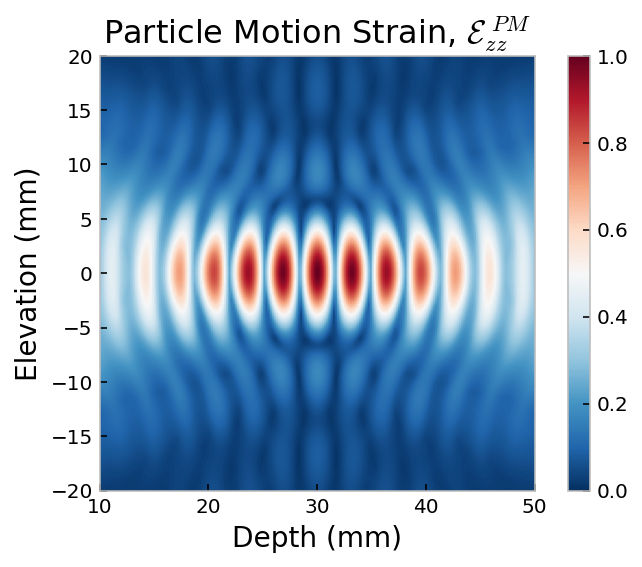

In [24]:
plt.title('Particle Motion Strain, $\mathcal{E}^{\ PM}_{zz}$', fontsize=16)
plt.imshow(PM_exx_envelope_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.grid(False)
plt.colorbar()
plt.clim(0, 1)
plt.xlabel('Depth (mm)', fontsize=14)
plt.ylabel('Elevation (mm)', fontsize=14)

#plt.savefig(figure_path + 'PM_strain_max.png', dpi=600)
plt.show()

### Comparing Independently Normalized Strain Fields

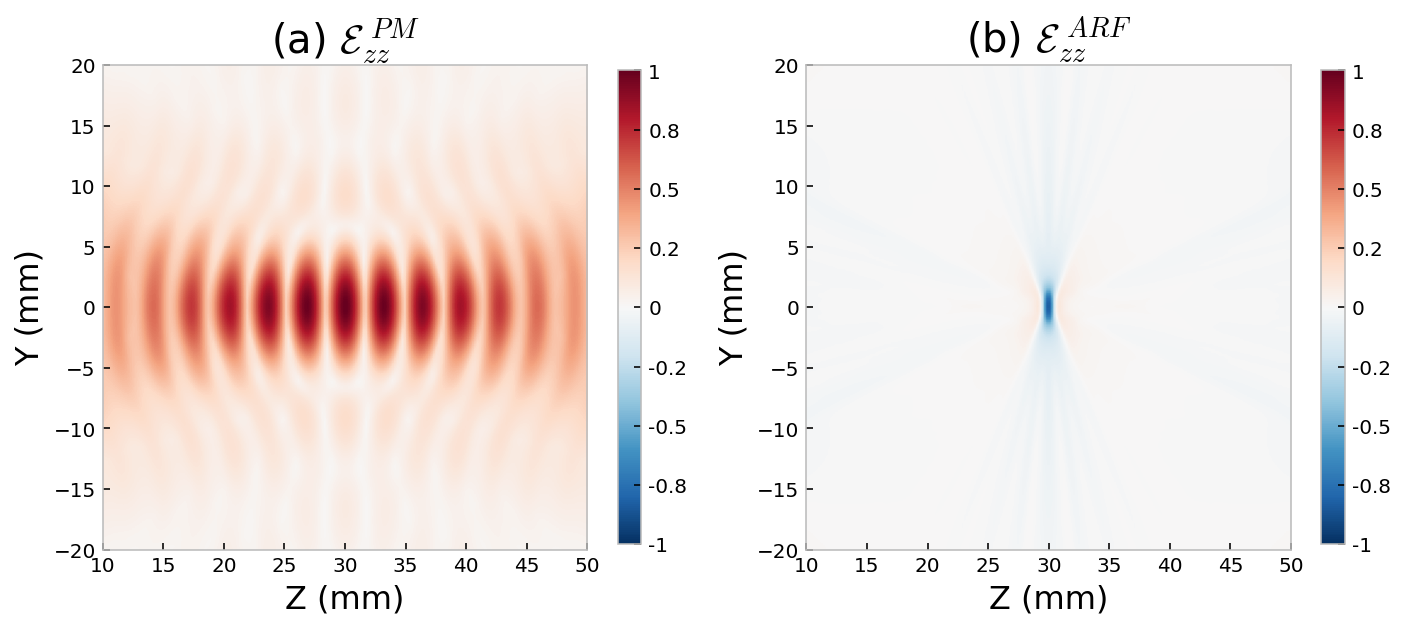

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('(a) $\mathcal{E}^{\ PM}_{zz}$', fontsize=20)
plt.imshow(PM_exx_envelope_norm[50:-50, 50:-50],
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.grid(False)
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)

plt.subplot(1, 2, 2)
plt.title('(b) $\mathcal{E}^{\ ARF}_{zz}$', fontsize=20)
plt.imshow(gaussian_filter(ARF_exx_norm[50:-50, 50:-50], 1),
           extent=dynamic_extent(50, 50), cmap='RdBu_r')
plt.colorbar(shrink=0.7, format='%0.0g')
plt.clim(-1, 1)
plt.xlabel('Z (mm)', fontsize=16)
plt.ylabel('Y (mm)', fontsize=16)
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'ARF_PM_strain_comparison.png', dpi=600)
plt.show()

Save the peak strain components, both PM strain and ARF strain, for comparison against other configurations:

In [26]:
np.save(file_path + 'PM_strain_zz', PM_exx_envelope)
np.save(file_path + 'ARF_strain_zz', ARF_exx)